# CAP 6618 - Machine Learning for Computer Vision

# Programming Project 4

### The following was adapted from the YouTube channel deeplizard. 
### Specifically: https://www.youtube.com/watch?v=OO4HD-1wRN8

### Imports

In [2]:
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline


In [49]:
# Borrowed from scikit learn

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Try out MobileNet.  Great for smaller, mobile devices. MobileNet is around 17mb compared to VGG16's 553.

In [3]:
# Returns a pre-trained MobileNet model which has weights that were saved from being
# trained on images form the ImageNet dataset
mobile = keras.applications.mobilenet.MobileNet()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
17227776/17225924 [==============================] - 5s 0us/step


In [5]:
# Pre-process an image file into a format which MobileNet expects

def prepare_image(file):
    # Image path on local disk
    img_path = 'MobileNet-inference-images/'
    # Returns a PIL image
    img = image.load_img(img_path + file, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

### Let's test out the model

In [10]:
pre_processed_image = prepare_image('elephant.jpg')
predictions = mobile.predict(pre_processed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n02504458', 'African_elephant', 0.82401997),
  ('n01871265', 'tusker', 0.14276642),
  ('n02504013', 'Indian_elephant', 0.0332112),
  ('n01704323', 'triceratops', 1.1801613e-06),
  ('n01695060', 'Komodo_dragon', 4.1861566e-07)]]

#### 81% sure that it's an African Elephant. Not quite as good as ResNet50's 91%, but not bad.

In [11]:
pre_processed_image = prepare_image('squirrel.jpg')
predictions = mobile.predict(pre_processed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n02098286', 'West_Highland_white_terrier', 0.50202197),
  ('n01877812', 'wallaby', 0.042076115),
  ('n02100735', 'English_setter', 0.024773598),
  ('n02326432', 'hare', 0.023596372),
  ('n02325366', 'wood_rabbit', 0.021064676)]]

#### An image of a squirrel I took 20 years ago for some reason. Anyway, looks like it's not sure what it is.

In [23]:
train_path = 'cats-and-dogs/train'

test_path = 'cats-and-dogs/test'

#### I grabbed the cats vs dogs dataset from Kaggle

In [24]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(train_path, target_size=(224,224), batch_size=100)

test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=100, shuffle = False)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [25]:
mobile = keras.applications.mobilenet.MobileNet()

In [26]:
mobile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [27]:
# Grab the output of the 6th to last layer of the original mobilnet to use in a new model.
# The new model will consist of the original mobilnet, up to the 6th to last layer.
# So we are NOT including the last 5 layers of the original mobilnet model.
x = mobile.layers[-6].output

# Add an output layer with 2 output layers for cat and dog
predictions = Dense(2, activation='softmax')(x)

# Construct a new fine-tuned model
model = Model(inputs=mobile.input, outputs=predictions)

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [29]:
# Freeze all layers except the last 5. So only the last 5 layers will be trained.
for layer in model.layers[:-5]:
    layer.trainable = False

In [30]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# 8000 images, batchsize=100, steps_per_epoch=8000/100 = 80

model.fit_generator(train_batches, steps_per_epoch=80, validation_data=test_batches, validation_steps=2, epochs=5, verbose=2)

Epoch 1/5
 - 646s - loss: 0.1477 - acc: 0.9379 - val_loss: 0.0987 - val_acc: 0.9850
Epoch 2/5
 - 672s - loss: 0.0481 - acc: 0.9823 - val_loss: 0.0175 - val_acc: 0.9950
Epoch 3/5
 - 665s - loss: 0.0310 - acc: 0.9911 - val_loss: 0.0055 - val_acc: 1.0000
Epoch 4/5
 - 662s - loss: 0.0229 - acc: 0.9943 - val_loss: 0.0053 - val_acc: 0.9950
Epoch 5/5
 - 631s - loss: 0.0160 - acc: 0.9981 - val_loss: 0.0036 - val_acc: 1.0000


### Getting good results on both training and validation, around 99% Seens too good, I might be missing something.

In [33]:
test_labels = test_batches.classes
test_labels

array([0, 0, 0, ..., 1, 1, 1])

In [34]:
test_batches.class_indices

{'cats': 0, 'dogs': 1}

In [36]:
# 2000 images / batch size of 100 = 20 steps
predictions = model.predict_generator(test_batches, steps=20, verbose=0)

In [39]:
cm_plot_labels = ['cat', 'dog']

Confusion matrix, without normalization
[[903  97]
 [144 856]]


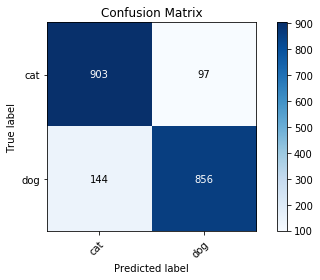

In [50]:
plot_confusion_matrix(test_labels, predictions.argmax(axis=1), cm_plot_labels, title='Confusion Matrix')